# setup

In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-b5356651-0d8e-5cd1-bdf3-ccbb8b221031"

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tuning_fun as tu
import emulator_fun as ef
import numpy as np
from tqdm.keras import TqdmCallback
import pandas as pd
import time
import netCDF4 as nc

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]  # in MB
#         )
#     except RuntimeError as e:
#         print(e)

# HP tuning

## pre-processing

In [3]:
case_name = 'condevp_withcoal_content'
base_path = '/Users/arthurhu/github/BOSS_PPE/summary_ncs/'
filename = case_name + '.nc'

param_all_idx = np.arange(40)
# REVIEW: check every time if this is true ... not sure how to implement this programatically
# param_interest_idx = np.arange(16,28)
# param_interest_idx = np.arange(28,40)
param_interest_idx = np.arange(0,28)
# param_interest_idx = np.arange(12)
# param_interest_idx = np.concatenate((np.arange(0,8), np.arange(16,28)))
param_not_int_idx = [i for i in param_all_idx if i not in param_interest_idx]

param_train = ef.get_params(base_path, filename, param_interest_idx)

In [4]:
nppe, npar = param_train['vals'].shape

In [5]:
dataset = nc.Dataset(base_path + filename, mode='r')

In [6]:
eff0s = getattr(dataset, 'thresholds_eff0')
var_constraints = getattr(dataset, 'var_constraints')
ppe_var_names = ['boss_' + i for i in var_constraints]
ppe_raw_vals = [dataset.variables[i][:] for i in ppe_var_names]
tgt_var_names = ['bin_' + i for i in var_constraints]
tgt_raw_vals = [dataset.variables[i][:] for i in tgt_var_names]

In [7]:
nobs = int(sum([ppe_raw_vals[i].size for i in range(len(var_constraints))])/nppe)

In [8]:
ppe_var_presence = ppe_asinh = ppe_all = np.empty((nppe,0), dtype=np.float32)
ncases = tgt_raw_vals[0].shape[0]
tgt_var_presence = tgt_asinh = tgt_all = np.empty((ncases,0), dtype=np.float32)

for idx, eff0 in enumerate(eff0s):
    if ppe_raw_vals[idx].ndim >= 2:
        ppe_raw_val_reshaped = np.reshape(ppe_raw_vals[idx], (nppe, np.product(ppe_raw_vals[idx].shape[1:])))
        tgt_raw_val_reshaped = np.reshape(tgt_raw_vals[idx], (ncases, np.product(tgt_raw_vals[idx].shape[1:])))
    else:
        ppe_raw_val_reshaped = ppe_raw_vals[idx].reshape(-1, 1)
        tgt_raw_val_reshaped = tgt_raw_vals[idx].reshape(-1, 1)
    ppe_var_presence = np.concatenate((ppe_var_presence, ppe_raw_val_reshaped > eff0s[idx]/100), axis=1)
    ppe_asinh_reshaped = ef.smooth_linlog(ppe_raw_val_reshaped, eff0)
    ppe_asinh = np.concatenate((ppe_asinh, ppe_asinh_reshaped), axis=1)
    tgt_var_presence = np.concatenate((tgt_var_presence, tgt_raw_val_reshaped > eff0s[idx]/100), axis=1)
    tgt_asinh_reshaped = ef.smooth_linlog(tgt_raw_val_reshaped, eff0)
    tgt_asinh = np.concatenate((tgt_asinh, tgt_asinh_reshaped), axis=1)


In [9]:
from sklearn import preprocessing
import sklearn.model_selection as mod_sec

minmaxscale = preprocessing.MinMaxScaler().fit(param_train['vals'])
x_all = minmaxscale.transform(param_train['vals'])

standscale = preprocessing.StandardScaler().fit(ppe_asinh)
ppe_all = standscale.transform(ppe_asinh)
tgt_all = standscale.transform(tgt_asinh)

In [10]:
x_train, x_val, y_train_wpresence, y_val_wpresence = mod_sec.train_test_split(x_all, ppe_var_presence, test_size=0.2, random_state=1)
_, _, y_train, y_val = mod_sec.train_test_split(x_all, ppe_all, test_size=0.2, random_state=1)

y_train = np.nan_to_num(y_train, nan=-1001)
y_val = np.nan_to_num(y_val, nan=-1001)

(array([5.759e+04, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

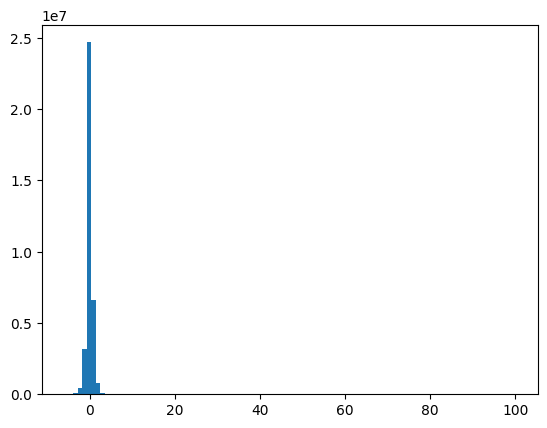

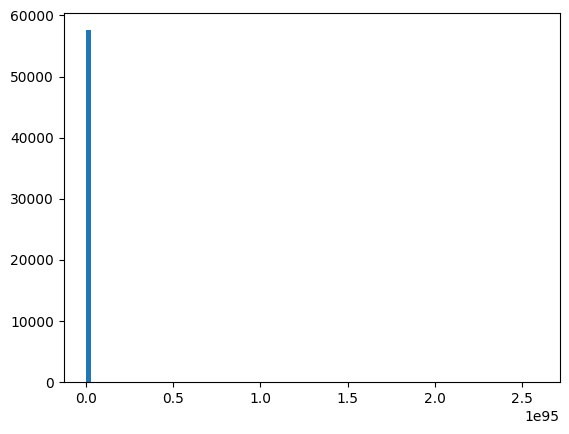

In [11]:
# np.sum(ppe_sim_train['vals'] > y_thresholds)
# test = np.log10(tgt_sim['vals'][0,7204:10804])
# test_finite = test[np.isfinite(test)]
a = 0
# ytrue = tgt_sim['vals'][:,a+6:a+3606]
# ytrue[~np.isfinite(ytrue)] = np.nan
# plt.hist(ytrue.flatten())
# plt.figure()
# plt.hist(y_all[:,5:65].flatten(), bins=100)
# plt.figure()
# plt.hist(tgt_all[:,5:65].flatten(), bins=100)

plt.hist(ppe_all[:,a+4:a+3604].flatten(), bins=100)
plt.figure()
plt.hist(tgt_all[:,a+4:a+3604].flatten(), bins=100)

In [12]:
np.mean(tgt_all[0,a+4:a+3604])

9.018646353519051e+79

## separate class/reg training

### classifier

In [ ]:
proj_name = 'class_try2_stopearly'

tuner_classifier = kt.RandomSearch(
    lambda hp: tu.build_classifier_model(hp, npar, nobs),
    objective='val_accuracy',
    max_trials=20,
    directory='hp_tuning_withclass/separate_models',
    project_name=proj_name
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

tuner_classifier.search(x_train, y_train_wpresence,
                          epochs=50,
                          validation_data=(x_val, y_val_wpresence),
                          callbacks=[stop_early])
best_classifier = tuner_classifier.get_best_models(num_models=1)[0]

In [ ]:
best_hps = tuner_classifier.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

In [ ]:
# Extract trial information
trial_ids = []
val_losses = []
for trial_id, trial in tuner_classifier.oracle.trials.items():
    # Ensure there's a recorded validation loss
    val_loss = trial.metrics.get_last_value('val_accuracy')
    if val_loss is not None:
        trial_ids.append(int(trial_id))
        val_losses.append(val_loss)

# Plot validation loss vs. trial number
plt.figure(figsize=(8, 4))
plt.scatter(trial_ids, val_losses)
plt.xlabel("Trial Number")
plt.ylabel("Validation Accuracy")
plt.title("Hyperparameter Tuning Performance")
plt.show()


In [ ]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = best_classifier.fit(x_train, y_train_wpresence,
                    epochs=1000,
                    validation_data=(x_val, y_val_wpresence),
                    verbose=0,
                    callbacks=[stop_early, TqdmCallback(verbose=1)])

# ef.clear_gpu_memory()

In [ ]:
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])

In [ ]:
wpresence_mask = y_train_wpresence == 1
print(wpresence_mask)

In [ ]:
x_train.shape

### regressor

## multi-output model

In [ ]:
proj_name = 'try38_fullmic_M3069'
tuner = kt.RandomSearch(
    lambda hp: tu.build_classreg_model(hp, npar, nobs),
    objective="val_loss",
    max_trials=100,
    directory='hp_tuning_withclass/multi-output',
    project_name=proj_name,
)


stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(
    x_train,
    {'presence': y_train_wpresence, 'water': y_train},
    epochs=50,
    validation_data=(x_val, {'presence': y_val_wpresence, 'water': y_val}),
    callbacks=([stop_early])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)




Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
4                 |4                 |num_shared_layers
128               |128               |units_0
adam              |adam              |optimizer
2.9417e-05        |2.9417e-05        |adam_lr

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1.3201 - presence_accuracy: 0.0000e+00 - presence_loss: 0.6775 - water_loss: 0.6427 - water_mae: 0.4200 - val_loss: 1.1769 - val_presence_accuracy: 0.0000e+00 - val_presence_loss: 0.5829 - val_water_loss: 0.5929 - val_water_mae: 0.4125
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1.1545 - presence_accuracy: 0.0000e+00 - presence_loss: 0.5244 - water_loss: 0.6301 - water_mae: 0.4140 - val_loss: 0.9434 - val_presence_accuracy: 0.0000e+00 - val_presence_loss: 0.3523 - val_water_loss: 0.5900 - val_water_mae: 0.4101
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9572 - presence_accuracy: 0.0000e+00 - presence_loss: 0.3230 - wat

In [ ]:
best_model.summary()

In [ ]:
# stop_early = keras.callbacks.EarlyStopping(monitor='val_presence_accuracy', mode='max', patience=2000)

train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, {'presence': y_train_wpresence, 'water': y_train}))
                 .shuffle(buffer_size=len(x_train))
                 .cache()
                 .batch(32)
                 .prefetch(tf.data.AUTOTUNE))

val_dataset = (tf.data.Dataset.from_tensor_slices((x_val, {'presence': y_val_wpresence, 'water': y_val}))
               .cache()
               .batch(32)
               .prefetch(tf.data.AUTOTUNE))

history = best_model.fit(
    train_dataset,
    epochs=15000,
    verbose=0,
    validation_data=val_dataset,
    callbacks=[TqdmCallback(verbose=1)]
)


In [ ]:
plt.figure()
plt.plot(history.epoch, history.history['presence_accuracy'], label='Training')
plt.plot(history.epoch, history.history['val_presence_accuracy'], label='Validation')
plt.ylabel('Water Presence Accuracy')
plt.legend()

plt.figure()
plt.plot(history.epoch, history.history['water_loss'], label='Training')
plt.plot(history.epoch, history.history['val_water_loss'], label='Validation')
plt.ylabel('Water Content Loss')
plt.legend()

In [ ]:
# save model:
best_model.save('models/multioutput_' + proj_name + '.keras')

## validation

In [ ]:
# best_model = tf.keras.models.load_model('models/multioutput_try28_condcoll_fullmom_nopartition_asinh.keras', compile=False)
plt.plot(best_model(x_val)[1][:, 0])
# cc_model(x_val)[1]

In [ ]:
plt.plot(y_val[:,0])

In [ ]:
y_pred = standscale.inverse_transform(best_model(x_val)[1].numpy())
# y_pred = model(x_val)
plt.plot(y_pred[:,0])

In [ ]:
standscale.inverse_transform(y_train)

In [ ]:
np.mean(y_pred[:, 0]), np.mean(standscale.inverse_transform(y_train)[:, 0])

In [ ]:
y_pred.shape

In [ ]:
y_pred = standscale.inverse_transform(best_model(x_val)[1].numpy())
# y_pred = standscale.inverse_transform(model(x_val).numpy())
# y_pred = np.exp(standscale.inverse_transform(model(x_val).numpy()))
y_val_lin = standscale.inverse_transform(y_val)
# y_train_lin = np.exp(standscale.inverse_transform(y_train))

fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(1,4)
for i in range(len(eff0)):
    ax = fig.add_subplot(gs[i])
    ax.set_aspect('equal')
    plt.scatter(y_val_lin[:,i], y_pred[:,i], alpha=0.05,c='k')
    # plt.scatter(ppe_sim_valid['vals'][:,i], y_pred[:,i],alpha=0.2,c='k')
    # plt.scatter(y_val[:,i], y_pred[:,i],alpha=0.2,c='k')
    plt.title(ppe_sim_train['var_names'][i])
    ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
    ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
    plt.plot([ax_min, ax_max], [ax_min, ax_max])
    # ax.set_xscale('log')
    # ax.set_yscale('log')
# fig.tight_layout()
# plt.savefig(plot_dir + proj_name + '.png')